In [2]:
"""
This file is used to load and run a trained model. for evaluation purposes.
"""
import os
import sys
# adding project directory to path, this is a bit hacky and may not work for all
sys.path.insert(0, os.path.abspath(os.path.dirname(os.path.abspath(''))))

import torch
from kbgen.config import rootdir
from kbgen.data.datasets import GSM
from kbgen.utils import get_key_padding_mask, Accuracy, TensorDict
from kbgen.utils.log import RunTracker
import os
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
import pandas as pd

plt.style.use("./mine.mplstyle")

In [3]:
# DATA -----------------------------------------------------
device = "cpu"
torch.set_default_device(device)
# Load Wandb Run -----------------------------------------------------
# You need to pick a run that is saved locally
model_name = "07-31-07-41-30MaskOnlyLoss_L2td4_te4_d512_periodic"
logdir = os.path.join(rootdir, "models", model_name)
run = RunTracker.from_logdir(logdir)
dataset = GSM.from_config(run.config, update=True)
assert run.config.fields == dataset.fields, "Fields do not match. Check that the dataset is the same as the one used for training."
model = run.load_latest_model()
model.eval()
model = model.to(device)

print(run.config)

Loading model from: /logdir/models/07-31-07-41-30MaskOnlyLoss_L2td4_te4_d512_periodic/0.pt
{'d_model': 512, 'd_ff_mult': 2, 'nhead': 2, 'num_layers': 2, 'field_encoder_layers': 2, 'field_decoder_layers': 3, 'num_emb': 'periodic', 'tie_numerical_embeddings': False, 'tie_numerical_decoders': False, 'tie_mask_embeddings': False, 'epochs': 1000, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 0, 'dropout': 0.0, 'mask_rate': [-1, 0.5], 'wandb': True, 'tags': ['MaskOnlyLoss'], 'device': 'cpu', 'seed': 42, 'rootdir': '/logdir', 'ckpt': '07-29-18-36-51rerun_L2td4_te4_d512_periodic', 'text_model': 'custom', 'tie_embeddings': True, 'tokenizer': 'gpt2', 'text_decoder_layers': 4, 'text_encoder_layers': 4, 'use_mup': True, 'num_fields': 12, 'vocab_size': 50258, 'fields': Fields([('numerical', ['phone.weight', 'phone.height', 'phone.depth', 'phone.width', 'phone.display_size', 'phone.battery', 'phone.launch.day', 'phone.launch.month', 'phone.launch.year']), ('categorical', ['phone.oem', 'phone.netwo

In [4]:
input_dict = dataset.test
key_padding_mask = dataset.pad_mask_dict.iloc[dataset.val_idx]

In [5]:
subset = dataset.test.iloc(torch.arange(10)).to("cpu")
print(subset)
print(*dataset.tokenizer.batch_decode(subset["phone.model"]), sep="\n")

{'phone.weight': tensor([1.0422, 1.1986, 1.0551, 1.0576, 1.0616, 1.0472, 1.0521, 1.0452, 1.0809,
        1.0775]), 'phone.height': tensor([1.1423, 1.4244, 1.1947, 1.1817, 1.1679, 1.1768, 1.2379, 1.1936, 1.2659,
        1.2808]), 'phone.depth': tensor([1.3467, 1.1200, 1.1827, 1.2867, 1.3333, 1.2427, 1.3200, 1.1653, 1.1307,
        1.1187]), 'phone.width': tensor([1.2217, 1.4579, 1.1357, 1.1350, 1.1234, 1.1245, 1.1245, 1.1058, 1.2067,
        1.2120]), 'phone.display_size': tensor([-1000.0000,     1.4040,     1.0831,     1.0831, -1000.0000,     1.0716,
        -1000.0000,     1.0487,     1.2321,     1.2321]), 'phone.battery': tensor([-1000.0000,     1.8956,     1.6976,     1.7301,     1.7751, -1000.0000,
            1.7118,     1.7118,     1.8296,     1.8093]), 'phone.launch.day': tensor([-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000.]), 'phone.launch.month': tensor([    1.9091,     1.0000,     1.0000,     1.9091,     1.5455,     1.0909,
        -1

In [6]:
# let's scale the weight property using its range and see how display size changes
def resample(resampled_field="phone.launch.year", n_samples=100):
    new_samples = dict()
    for field in dataset.fields.all_fields:
        if field == resampled_field:
            new_samples[field] = torch.linspace(1, 2, n_samples)
        else:
            new_samples[field] = dataset.test[field][:n_samples]
    
    new_samples = TensorDict(new_samples, fields=dataset.fields).to(device)
    return new_samples, None

def get_masked_preds(unmasked_field, new_samples, key_padding_mask):
    idx = dataset.fields.all_fields.index(unmasked_field)
    n_samples = len(list(new_samples.values())[0])
    property_mask = torch.zeros(n_samples, len(dataset.fields.all_fields)) - torch.inf
    property_mask[:, idx] = 0
    with torch.no_grad():
        return model.get_predictions(new_samples, key_padding_mask, property_mask)
    
def get_data(unmasked_field, n_samples=100):
    new_samples, key_padding_mask = resample(unmasked_field, n_samples)
    preds = get_masked_preds(unmasked_field, new_samples, key_padding_mask)
    return preds, new_samples, key_padding_mask

In [7]:
preds, new_samples, _ = get_data(resampled_field:="phone.launch.year")

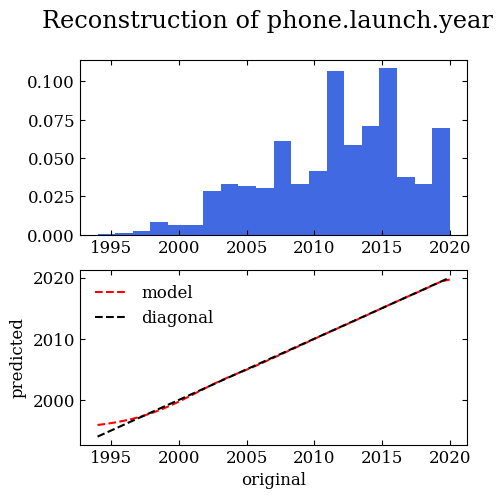

In [8]:
preds_resampled_field = preds[resampled_field].detach().cpu().numpy().flatten()
original = new_samples[resampled_field].detach().cpu().numpy().flatten()
train_data = dataset.train[resampled_field].detach().cpu().numpy().flatten()
train_data = train_data[train_data != dataset.numerical_pad_token_id]
train_data = dataset.reverse_transform({resampled_field: train_data})[resampled_field]
preds_resampled_field = dataset.reverse_transform({resampled_field: preds_resampled_field})[resampled_field]
original = dataset.reverse_transform({resampled_field: original})[resampled_field]

fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].hist(train_data, bins=20, density=True)
plt.plot(original, preds_resampled_field, ls="--", color="r", label="model")
plt.plot(original, original, ls="--", color="k", label="diagonal")
plt.xlabel("original")
plt.ylabel("predicted")
fig.suptitle(f"Reconstruction of {resampled_field}")
plt.legend()
plot_dir = os.path.join(rootdir, "plots", model_name)
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, f"reconstruction_{resampled_field}.png"))

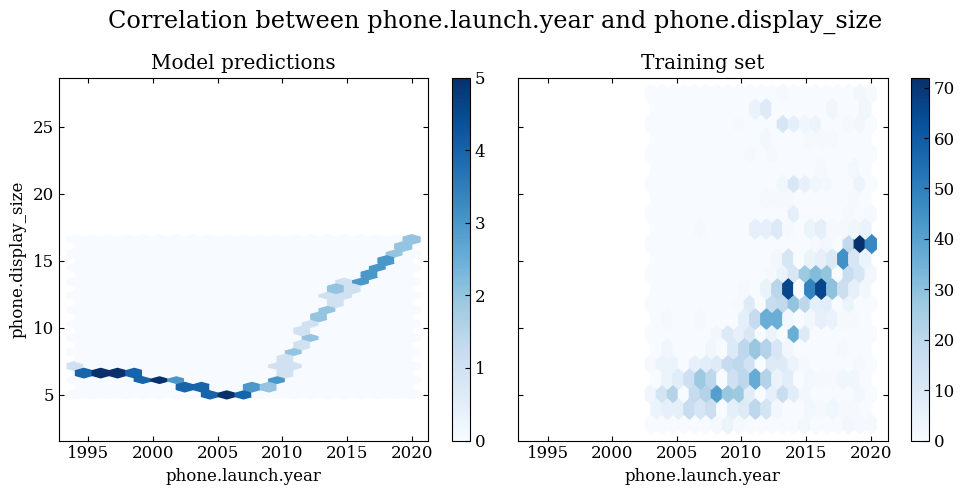

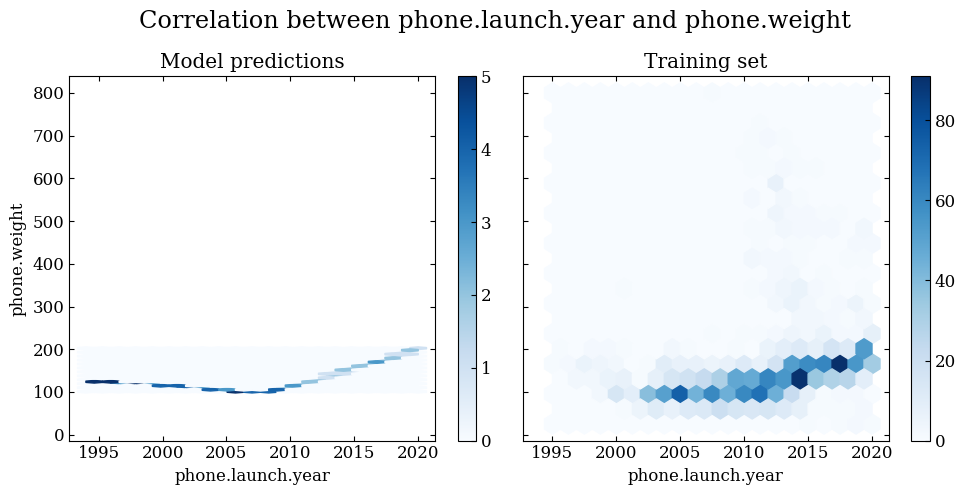

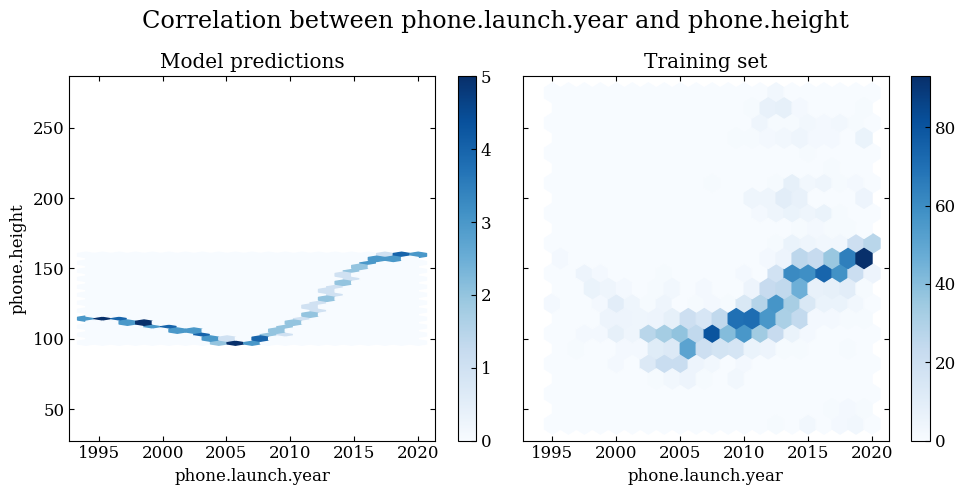

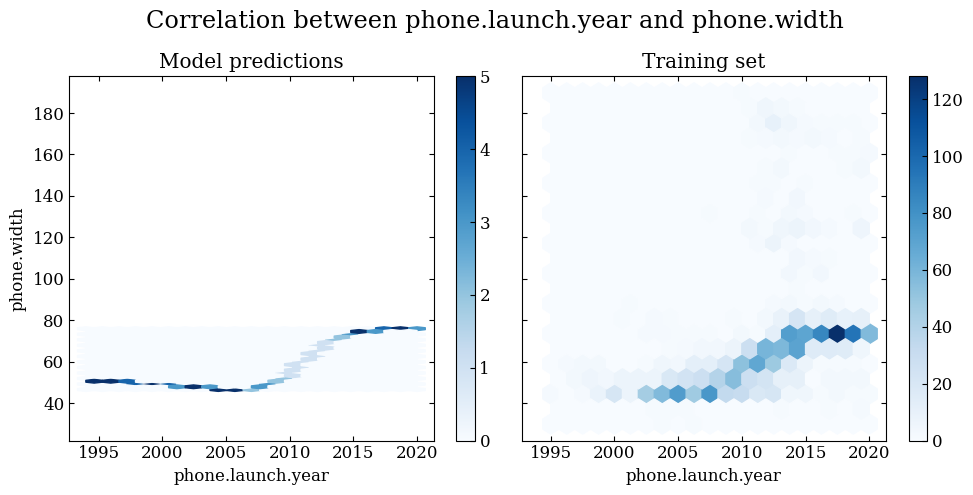

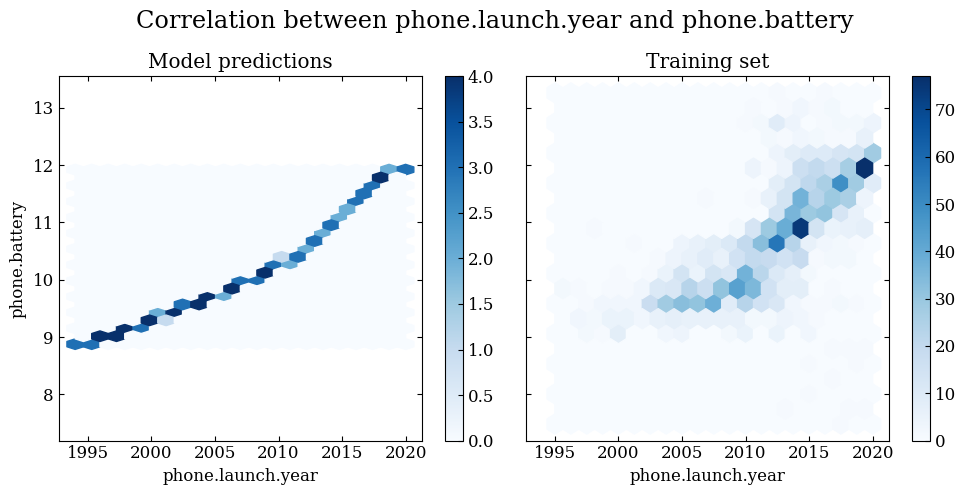

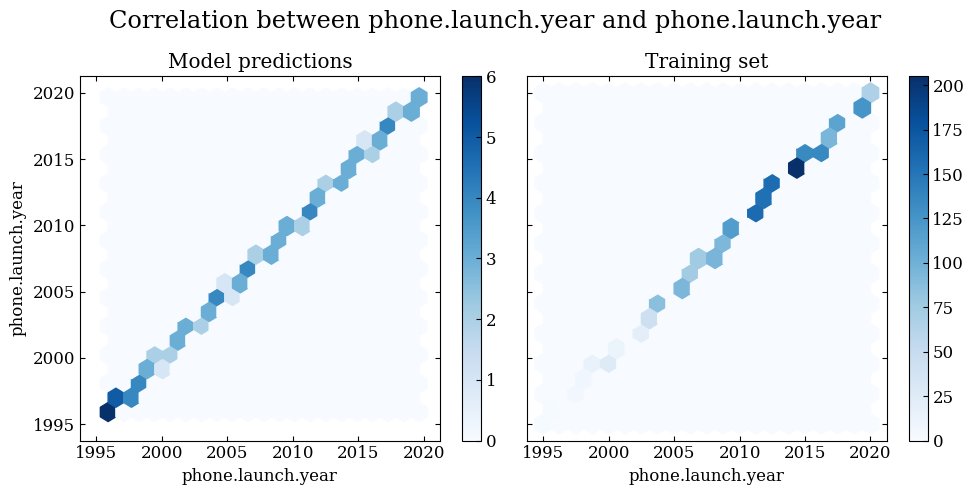

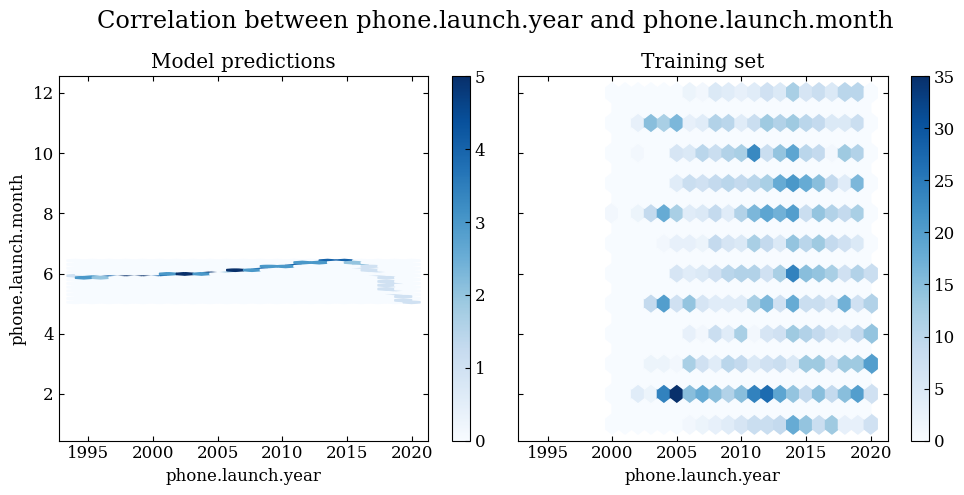

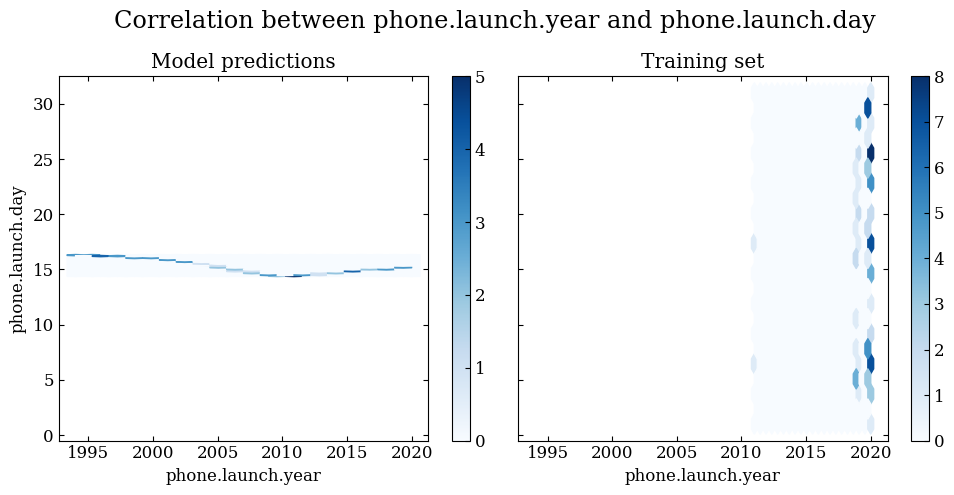

In [19]:
def hex_plot(x, y,x_name, y_name, gridsize=20, cmap="Blues", **kwargs):
    mask = (x != dataset.numerical_pad_token_id) & (y != dataset.numerical_pad_token_id)
    x = x[mask]
    y = y[mask]
    transformed = dataset.reverse_transform({x_name: x, y_name: y})
    x = transformed[x_name]
    y = transformed[y_name]
    df = pd.DataFrame({x_name: x, y_name: y})
    df.plot.hexbin(x=x_name, y=y_name, gridsize=gridsize, cmap=cmap, **kwargs)
    # add histogram of y values on the right
    # ax = foo.axes
    # ax2 = ax.twinx()
    # ax2.hist(y, bins=20, orientation="horizontal", color="k", alpha=0.5, density=True, histtype="step", log=True)
    # ax2.set_xlim(ax.get_ylim())
    # ax2.set_ylim(ax.get_xlim())
    # ax2.set_xlim
    # ax2.set_yticks([])
    return  x, y

for correlated_field in ["phone.display_size", "phone.weight", "phone.height", "phone.width", "phone.battery", "phone.launch.year","phone.launch.month", "phone.launch.day"] :
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = axes[0]
    hex_plot(new_samples[resampled_field].cpu(), preds[correlated_field].detach().view(-1).cpu(), resampled_field, correlated_field, ax=ax)
    ax.set_title(f"Model predictions")
    ax = axes[1]
    x,y = hex_plot(dataset.test[resampled_field].cpu(), dataset.test[correlated_field].cpu(), resampled_field, correlated_field, ax=ax)
    ax.set_title(f"Training set")
    fig.suptitle(f"Correlation between {resampled_field} and {correlated_field}")
    fig.tight_layout()
    # for ax in axes:
        # ax.axhline(y.median(), ls="--", color="k", label="mean")
    # add histogram of y values on the right
    # ax2 = ax.twinx()
    # ax2.hist(y, bins=20, orientation="horizontal", color="k", alpha=0.5, density=True, histtype="step", log=True)
    # ax2.set_ylim((0, 2))
    # plt.savefig(os.path.join(plot_dir, f"hexbin_{resampled_field}_{correlated_field}.png"))

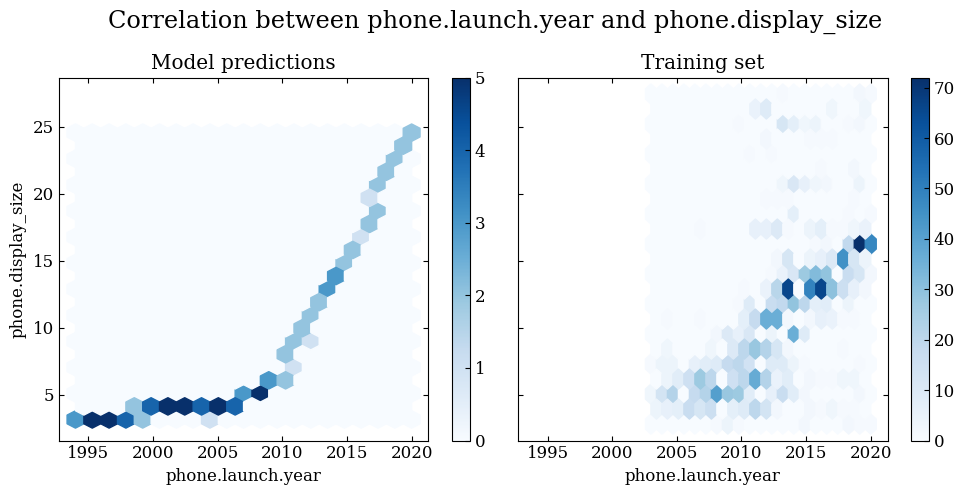

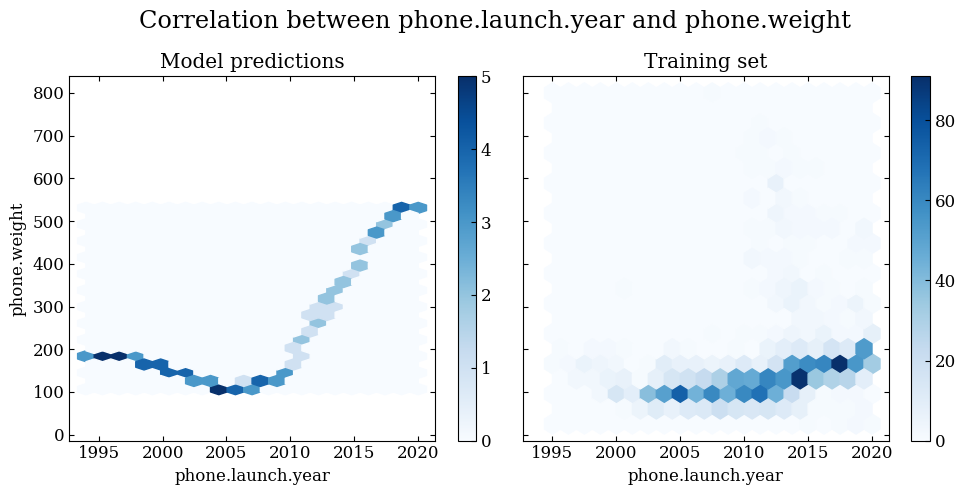

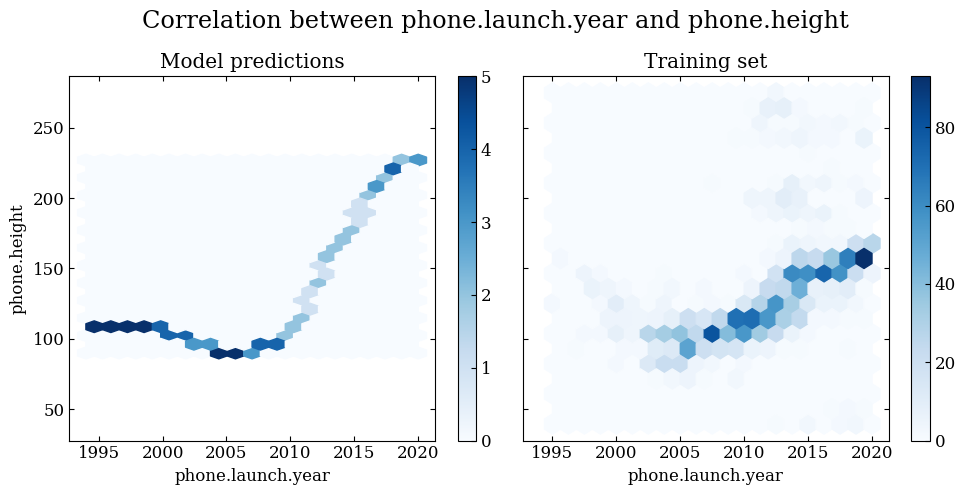

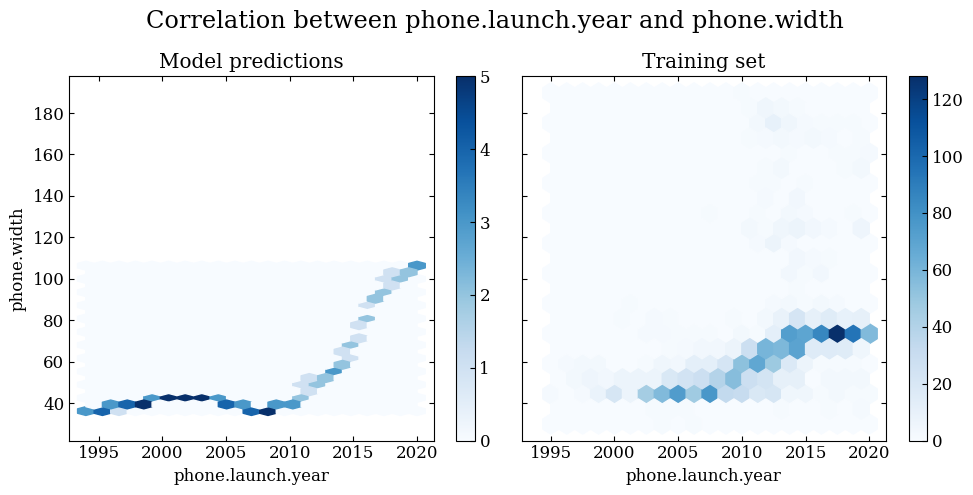

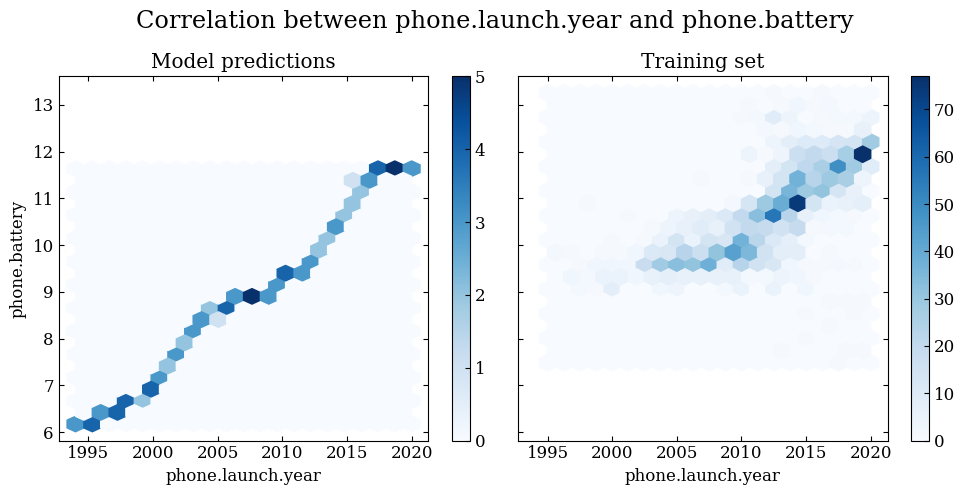

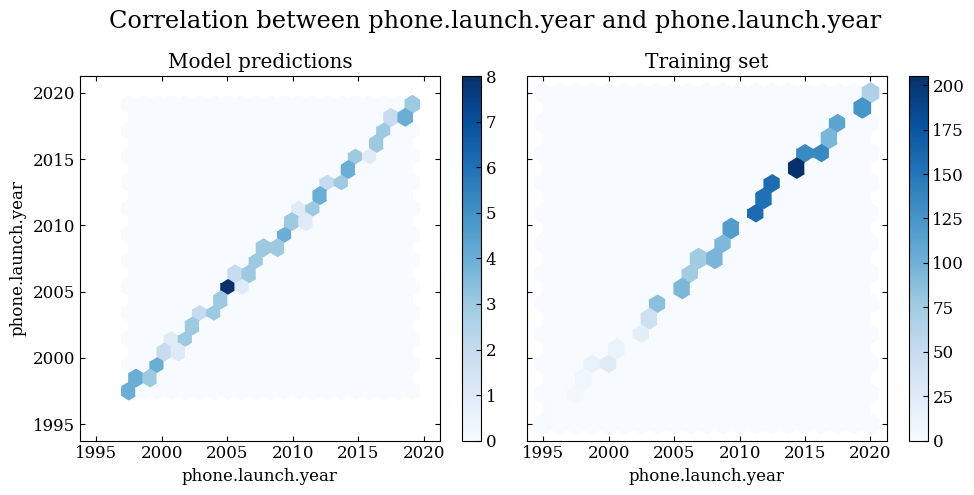

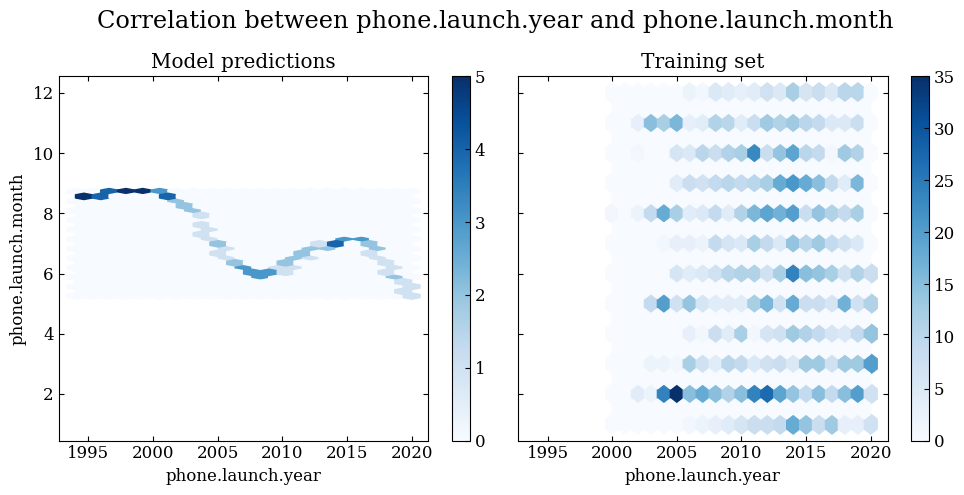

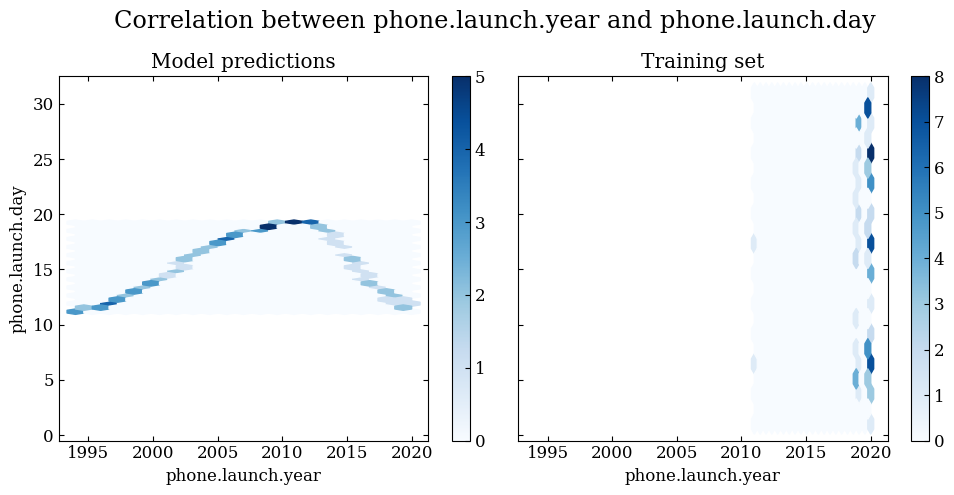

In [ ]:
def hex_plot(x, y,x_name, y_name, gridsize=20, cmap="Blues", **kwargs):
    mask = (x != dataset.numerical_pad_token) & (y != dataset.numerical_pad_token)
    x = x[mask]
    y = y[mask]
    transformed = dataset.reverse_transform({x_name: x, y_name: y})
    x = transformed[x_name]
    y = transformed[y_name]
    df = pd.DataFrame({x_name: x, y_name: y})
    df.plot.hexbin(x=x_name, y=y_name, gridsize=gridsize, cmap=cmap, **kwargs)
    # add histogram of y values on the right
    # ax = foo.axes
    # ax2 = ax.twinx()
    # ax2.hist(y, bins=20, orientation="horizontal", color="k", alpha=0.5, density=True, histtype="step", log=True)
    # ax2.set_xlim(ax.get_ylim())
    # ax2.set_ylim(ax.get_xlim())
    # ax2.set_xlim
    # ax2.set_yticks([])
    return  x, y

for correlated_field in ["phone.display_size", "phone.weight", "phone.height", "phone.width", "phone.battery", "phone.launch.year","phone.launch.month", "phone.launch.day"] :
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = axes[0]
    hex_plot(new_samples[resampled_field].cpu(), preds[correlated_field].detach().view(-1).cpu(), resampled_field, correlated_field, ax=ax)
    ax.set_title(f"Model predictions")
    ax = axes[1]
    x,y = hex_plot(dataset.test[resampled_field].cpu(), dataset.test[correlated_field].cpu(), resampled_field, correlated_field, ax=ax)
    ax.set_title(f"Training set")
    fig.suptitle(f"Correlation between {resampled_field} and {correlated_field}")
    fig.tight_layout()
    # for ax in axes:
        # ax.axhline(y.median(), ls="--", color="k", label="mean")
    # add histogram of y values on the right
    # ax2 = ax.twinx()
    # ax2.hist(y, bins=20, orientation="horizontal", color="k", alpha=0.5, density=True, histtype="step", log=True)
    # ax2.set_ylim((0, 2))
    # plt.savefig(os.path.join(plot_dir, f"hexbin_{resampled_field}_{correlated_field}.png"))